## Exploratory Data Analysis

In [13]:
import gc
import pandas as pd
import numpy as np
import lightgbm as lgb
from operator import xor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from ml_metrics import rmsle
%matplotlib inline

le = preprocessing.LabelEncoder()
lb = preprocessing.LabelBinarizer()

air = {
    "reserve": pd.read_csv("data/air/air_reserve.csv", parse_dates=["visit_datetime", "reserve_datetime"]),
    "store_info": pd.read_csv("data/air/air_store_info.csv"),
    "visit_data": pd.read_csv("data/air/air_visit_data.csv", parse_dates=["visit_date"])
}

hpg = {
    "reserve": pd.read_csv("data/hpg/hpg_reserve.csv", parse_dates=["visit_datetime", "reserve_datetime"]),
    "store_info": pd.read_csv("data/hpg/hpg_store_info.csv")
}

date_info = pd.read_csv("data/date_info.csv", parse_dates=["calendar_date"])
store_id_relation = pd.read_csv("data/store_id_relation.csv")

def remove_outliers(data):
    df_0 = data.loc[data.visitors == 0]   
    q1 = np.percentile(data.visitors, 25, axis=0)
    q3 = np.percentile(data.visitors, 75, axis=0)
    k = 2.8
    iqr = q3 - q1
    df_temp = data.loc[data.visitors > q1 - k*iqr]
    df_temp = data.loc[data.visitors < q3 + k*iqr]
    frames = [df_0, df_temp]
    result = pd.concat(frames)
    return result

air["visit_data"] = remove_outliers(air["visit_data"])

df_test = pd.read_csv('sample_submission.csv')
df_test.head()
df_test['air_store_id'] = df_test['id'].apply(lambda x: '_'.join(x.split('_')[:2]))
df_test['visit_date'] = df_test['id'].apply(lambda x: x.split('_')[-1])
df_test.head()
index_test = df_test['id']
df_test.head()
del df_test['id'], df_test['visitors']

In [14]:
print('mapping and dropping useless information in df_hr ...')
s_1 = store_id_relation['air_store_id']
s_2 = store_id_relation['hpg_store_id']
a_h_map = dict(zip(s_2.values, s_1.values))
del s_1, s_2

hpg["reserve"]['air_store_id'] = hpg["reserve"]['hpg_store_id'].map(a_h_map)
hpg["reserve"] = hpg["reserve"].drop('hpg_store_id', axis=1).dropna()


print('mapping and dropping useless information in df_hr Done!')
print("-----------------------------------------------------------------------------------------")

print('mapping and dropping useless information in df_hr ...')

hpg["store_info"]['air_store_id'] = hpg["store_info"]['hpg_store_id'].map(a_h_map)
hpg["store_info"] = hpg["store_info"].drop('hpg_store_id', axis=1).dropna()
print('mapping and dropping useless information in df_hs Done!')
gc.collect()

mapping and dropping useless information in df_hr ...
mapping and dropping useless information in df_hr Done!
-----------------------------------------------------------------------------------------
mapping and dropping useless information in df_hr ...
mapping and dropping useless information in df_hs Done!


144

## Feature Analysis

###### Looking for correlations in data:

In [15]:
air["visit_data"]["num_of_week"] = air["visit_data"]["visit_date"].dt.dayofweek

corr_table = air["visit_data"]
corr_table["visitors"] = corr_table["visitors"].map(np.log1p)
corr_table = pd.merge(corr_table, air["store_info"], on="air_store_id")
corr_table = pd.merge(corr_table, date_info,
                      left_on="visit_date", right_on="calendar_date")
corr_table["air_area_name"] = corr_table["air_area_name"].str.partition(" ")
corr_table["weekend_flg"] = corr_table["num_of_week"].map(lambda n: 1 if n in (1,2) else 0)
corr_table["not_workday_flg"] = corr_table["holiday_flg"].combine(corr_table["weekend_flg"], xor)
corr_table = corr_table.drop(columns=["day_of_week", "visit_date"])
print(corr_table.head())

           air_store_id  visitors  num_of_week air_genre_name air_area_name  \
0  air_ba937bf13d40fb24  3.258097            2     Dining bar      Tōkyō-to   
1  air_25e9888d30b386df  3.091042            2        Izakaya      Tōkyō-to   
2  air_fd6aac1043520e83  3.713572            2        Izakaya      Tōkyō-to   
3  air_64d4491ad8cdb1c6  1.791759            2     Dining bar      Tōkyō-to   
4  air_ee3a01f0c71a769f  2.944439            2    Cafe/Sweets  Shizuoka-ken   

    latitude   longitude calendar_date  holiday_flg  weekend_flg  \
0  35.658068  139.751599    2016-01-13            0            1   
1  35.626568  139.725858    2016-01-13            0            1   
2  35.658068  139.751599    2016-01-13            0            1   
3  35.658068  139.751599    2016-01-13            0            1   
4  34.710895  137.725940    2016-01-13            0            1   

   not_workday_flg  
0                1  
1                1  
2                1  
3                1  
4          

In [16]:
print(corr_table.corr())

                 visitors  num_of_week  latitude  longitude  holiday_flg  \
visitors         1.000000     0.157647 -0.005448  -0.005496     0.026258   
num_of_week      0.157647     1.000000  0.000692  -0.010221    -0.050779   
latitude        -0.005448     0.000692  1.000000   0.652618     0.001884   
longitude       -0.005496    -0.010221  0.652618   1.000000    -0.011837   
holiday_flg      0.026258    -0.050779  0.001884  -0.011837     1.000000   
weekend_flg     -0.081873    -0.500907  0.000979   0.012492    -0.091021   
not_workday_flg -0.070737    -0.490379  0.001420   0.008290     0.274802   

                 weekend_flg  not_workday_flg  
visitors           -0.081873        -0.070737  
num_of_week        -0.500907        -0.490379  
latitude            0.000979         0.001420  
longitude           0.012492         0.008290  
holiday_flg        -0.091021         0.274802  
weekend_flg         1.000000         0.886025  
not_workday_flg     0.886025         1.000000  


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A381F8B208>,
      dtype=object)

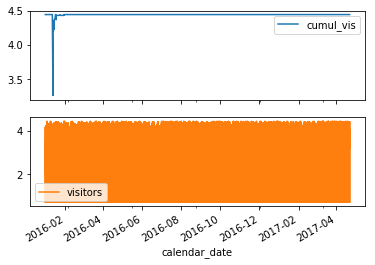

In [17]:
corr_table["cumul_vis"] = corr_table["visitors"].cummax()
corr_table.loc[:,["calendar_date", "cumul_vis", "visitors"]].plot.line(x="calendar_date", subplots=True)

# Applying ML

label encoding:

In [3]:
le.fit(air["store_info"]['air_genre_name'])
air["store_info"]['air_genre_name'] = le.fit_transform(air["store_info"]['air_genre_name'])

le.fit(air["store_info"]['air_area_name'])
air["store_info"]['air_area_name'] = le.fit_transform(air["store_info"]['air_area_name'])

le.fit(hpg["store_info"]['hpg_genre_name'])
hpg["store_info"]['hpg_genre_name'] = le.fit_transform(hpg["store_info"]['hpg_genre_name'])

le.fit(hpg["store_info"]['hpg_area_name'])
hpg["store_info"]['hpg_area_name'] = le.fit_transform(hpg["store_info"]['hpg_area_name'])



le.fit(air["store_info"]['air_store_id'])


air["reserve"]['air_store_id'] = le.transform(air["reserve"]['air_store_id'])
air["store_info"]['air_store_id'] = le.transform(air["store_info"]['air_store_id'])
air["visit_data"]['air_store_id'] = le.transform(air["visit_data"]['air_store_id'])
hpg["reserve"]['air_store_id'] = le.transform(hpg["reserve"]['air_store_id'])
hpg["store_info"]['air_store_id'] = le.transform(hpg["store_info"]['air_store_id'])

df_test['air_store_id'] = le.transform(df_test['air_store_id'])

gc.collect()

0

In [4]:
time_format = "%Y-%m-%d %H:%M:%S"
def seperate_date(data):
    # split date feature in reservation datetime
    data_time = pd.to_datetime(data.reserve_datetime, format=time_format)
    data['Year_re']= data_time.dt.year
    data['Month_re'] = data_time.dt.month
    data['DayOfYear_re'] = data_time.dt.dayofyear
    data['DayOfWeek_re'] = data_time.dt.dayofweek
    data['Hour_re'] = data_time.dt.hour
    return data

seperate_date(air["reserve"])


def seperate_date(data):
    # split date feature in reservation datetime
    data_time = pd.to_datetime(data.reserve_datetime, format=time_format)
    data['Year_re_h']= data_time.dt.year
    data['Month_re_h'] = data_time.dt.month
    data['DayOfYear_re_h'] = data_time.dt.dayofyear
    data['DayOfWeek_re_h'] = data_time.dt.dayofweek
    data['Hour_re_h'] = data_time.dt.hour
    return data

seperate_date(hpg["reserve"])


time_format = "%Y-%m-%d %H:%M:%S"
def seperate_date(data):
    # split date feature in reserved visiting datetime
    data_time = pd.to_datetime(data.visit_datetime, format=time_format)
    data['Year_re_visit']= data_time.dt.year
    data['Month_re_visit'] = data_time.dt.month
    data['DayOfYear_re_visit'] = data_time.dt.dayofyear
    data['DayOfWeek_re_visit'] = data_time.dt.dayofweek
    data['Hour_re_visit'] = data_time.dt.hour
    return data

seperate_date(air["reserve"])


def seperate_date(data):
    # split date feature in reserved visiting datetime
    data_time = pd.to_datetime(data.visit_datetime, format=time_format)
    data['Year_re_visit_h']= data_time.dt.year
    data['Month_re_visit_h'] = data_time.dt.month
    data['DayOfYear_re_visit_h'] = data_time.dt.dayofyear
    data['WeekOfYear_re_visit_h'] = data_time.dt.week
    data['DayOfWeek_re_visit_h'] = data_time.dt.dayofweek
    data['Hour_re_visit_h'] = data_time.dt.hour
    return data

seperate_date(hpg["reserve"])

print('seperating date time features done! ...')
gc.collect()

seperating date time features done! ...


142

Merge dataset

In [5]:
features_to_drop = [
        'air_store_id__'
        ]

def merge_df(data, data_to_join):
    # merge dataframes        
    data = data.join(data_to_join, on='air_store_id', rsuffix='__', how='left')   
    return data

def fix_data(data):
    # drop __ data    
    for feature in features_to_drop:
        data.drop(feature, axis=1)
    return data

# Merge to df_train
print('merging dataframes ...')
df_train = merge_df(air["visit_data"], air["reserve"])
df_train = merge_df(df_train, air["store_info"])

hpg["reserve"]['reserve_visitors_hr'] = hpg["reserve"]['reserve_visitors'] 
hpg["reserve"].drop('reserve_visitors', axis=1) 

hpg["store_info"]['latitude_hr'] = hpg["store_info"]['latitude'] 
hpg["store_info"].drop('latitude', axis=1)

hpg["store_info"]['longitude_hr'] = hpg["store_info"]['longitude'] 
hpg["store_info"].drop('longitude', axis=1) 

df_train = merge_df(df_train, hpg["store_info"])
df_train = merge_df(df_train, hpg["store_info"])
gc.collect()
fix_data(df_train)

# Merge to df_test

df_test = merge_df(df_test, air["reserve"])
df_test = merge_df(df_test, air["store_info"])

df_test = merge_df(df_test, hpg["store_info"])
df_test = merge_df(df_test, hpg["reserve"])
gc.collect()
fix_data(df_test)


print('merging dataframes done!')
gc.collect()
print("=========================================================================================")

merging dataframes ...
merging dataframes done!


drop date-time-hour info

In [6]:
def drop_datetime_info(data):
    data = data.drop(['visit_date', 'visit_datetime', 'reserve_datetime', 'visit_datetime__', 'reserve_datetime__'], axis=1)
    return data
df_train = drop_datetime_info(df_train)
df_test = drop_datetime_info(df_test)

In [7]:
train = df_train.fillna(-1)
test = df_test.fillna(-1)

shuffle dataset

In [8]:
from sklearn.utils import shuffle
train = shuffle(train, random_state=524)

X_pretrain, X_prevalid = train_test_split(train, test_size=0.05, random_state=1224, shuffle=False)

X_train = X_pretrain.drop(['visitors'], axis=1)
y_train = np.log1p(X_pretrain["visitors"].values)

X_valid = X_prevalid.drop(['visitors'], axis=1)
y_valid = np.log1p(X_prevalid['visitors'].values)

checking mean rmse

Test run without CV

In [9]:
print("Training LGBM model with cross-validation...")
params = {
    "application": "regression",
    "boosting": "gbdt",
    "learning_rate": 0.001,
    "num_leaves": 32,
    "min_sum_hessian_in_leaf": 1e-2,
    "min_gain_to_split": 0,
    
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8,
    "num_threads": 4,
    "metric": "rmse"
}

d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_valid, y_valid)

watchlist = [d_train, d_valid]

# default value of folds: 5
lgb_model1 = lgb.train(params, train_set=d_train, num_boost_round=37000, valid_sets=watchlist, verbose_eval=1000)

print("Model trained. Predicting...")

test_probs = lgb_model1.predict(test)
test_probs = np.expm1(test_probs)

result = pd.DataFrame({"id": index_test, "visitors": test_probs})
result.to_csv("LGB_sub.csv", index=False) # 0.60
print("Prediction complete.")

Training LGBM model with cross-validation...
[1000]	training's rmse: 0.741833	valid_1's rmse: 0.734585
[2000]	training's rmse: 0.706099	valid_1's rmse: 0.699121
[3000]	training's rmse: 0.682136	valid_1's rmse: 0.675538
[4000]	training's rmse: 0.664607	valid_1's rmse: 0.658298
[5000]	training's rmse: 0.651805	valid_1's rmse: 0.645935
[6000]	training's rmse: 0.64159	valid_1's rmse: 0.636245
[7000]	training's rmse: 0.633188	valid_1's rmse: 0.6282
[8000]	training's rmse: 0.626348	valid_1's rmse: 0.621683
[9000]	training's rmse: 0.620974	valid_1's rmse: 0.616687
[10000]	training's rmse: 0.61642	valid_1's rmse: 0.612475
[11000]	training's rmse: 0.612416	valid_1's rmse: 0.608808
[12000]	training's rmse: 0.609094	valid_1's rmse: 0.60577
[13000]	training's rmse: 0.60624	valid_1's rmse: 0.603276
[14000]	training's rmse: 0.604129	valid_1's rmse: 0.601476
[15000]	training's rmse: 0.602293	valid_1's rmse: 0.599785
[16000]	training's rmse: 0.600787	valid_1's rmse: 0.59842
[17000]	training's rmse: 0.